In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import random
import itertools
import matplotlib.pyplot as plt
import re
LOGS = "/Users/jairo/projects/wps/WellProdSim/logs/"

In [23]:
def dataset(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()

    filtered_lines = [line for line in lines if "PeasantFamilyBDIAgentBelieves" in line]

    data = []
    for line in filtered_lines:
        line = line.strip()  # Eliminar espacios en blanco al principio y al final
        line = line.replace(' ', '')  # Eliminar espacios en blanco entre las palabras

        # Extraer el valor de 'peasantProfile'
        peasant_profile_start = line.find('peasantProfile=') + len('peasantProfile=')
        peasant_profile_end = line.find(',', peasant_profile_start)
        peasant_profile = line[peasant_profile_start:peasant_profile_end]

        # Extraer la información entre las llaves {}
        start_index = line.find('{') + 1
        end_index = line.rfind('}')
        info = line[start_index:end_index]

        # Dividir la información en pares clave-valor
        pairs = info.split(',')
        row_dict = {}
        for pair in pairs:
            if '=' in pair:
                key, value = pair.split('=')
                row_dict[key] = value

        data.append(row_dict)

    return pd.DataFrame(data)

def get_simulation_time(filename):
    with open(filename, 'r') as f:
        lines = f.readlines()

    for line in lines:
        if "Simulation finished in" in line:
            words = line.split()
            for i, word in enumerate(words):
                if word == 'seconds.':
                    try:
                        time_seconds = float(words[i-1])
                        return time_seconds
                    except ValueError:
                        return None

    return None

df01 = dataset(LOGS + "wpsSimulator.log")

simulation_time = get_simulation_time(LOGS + "wpsSimulator.log")
if simulation_time:
    print("Simulation time:", simulation_time, "seconds")
else:
    print("Simulation time not found.")

Simulation time not found.


In [24]:
# Cambiar el nombre de la columna
df01 = df01.rename(columns={'PeasantFamilyBDIAgentBelieves{peasantProfile': 'peasantProfile'})

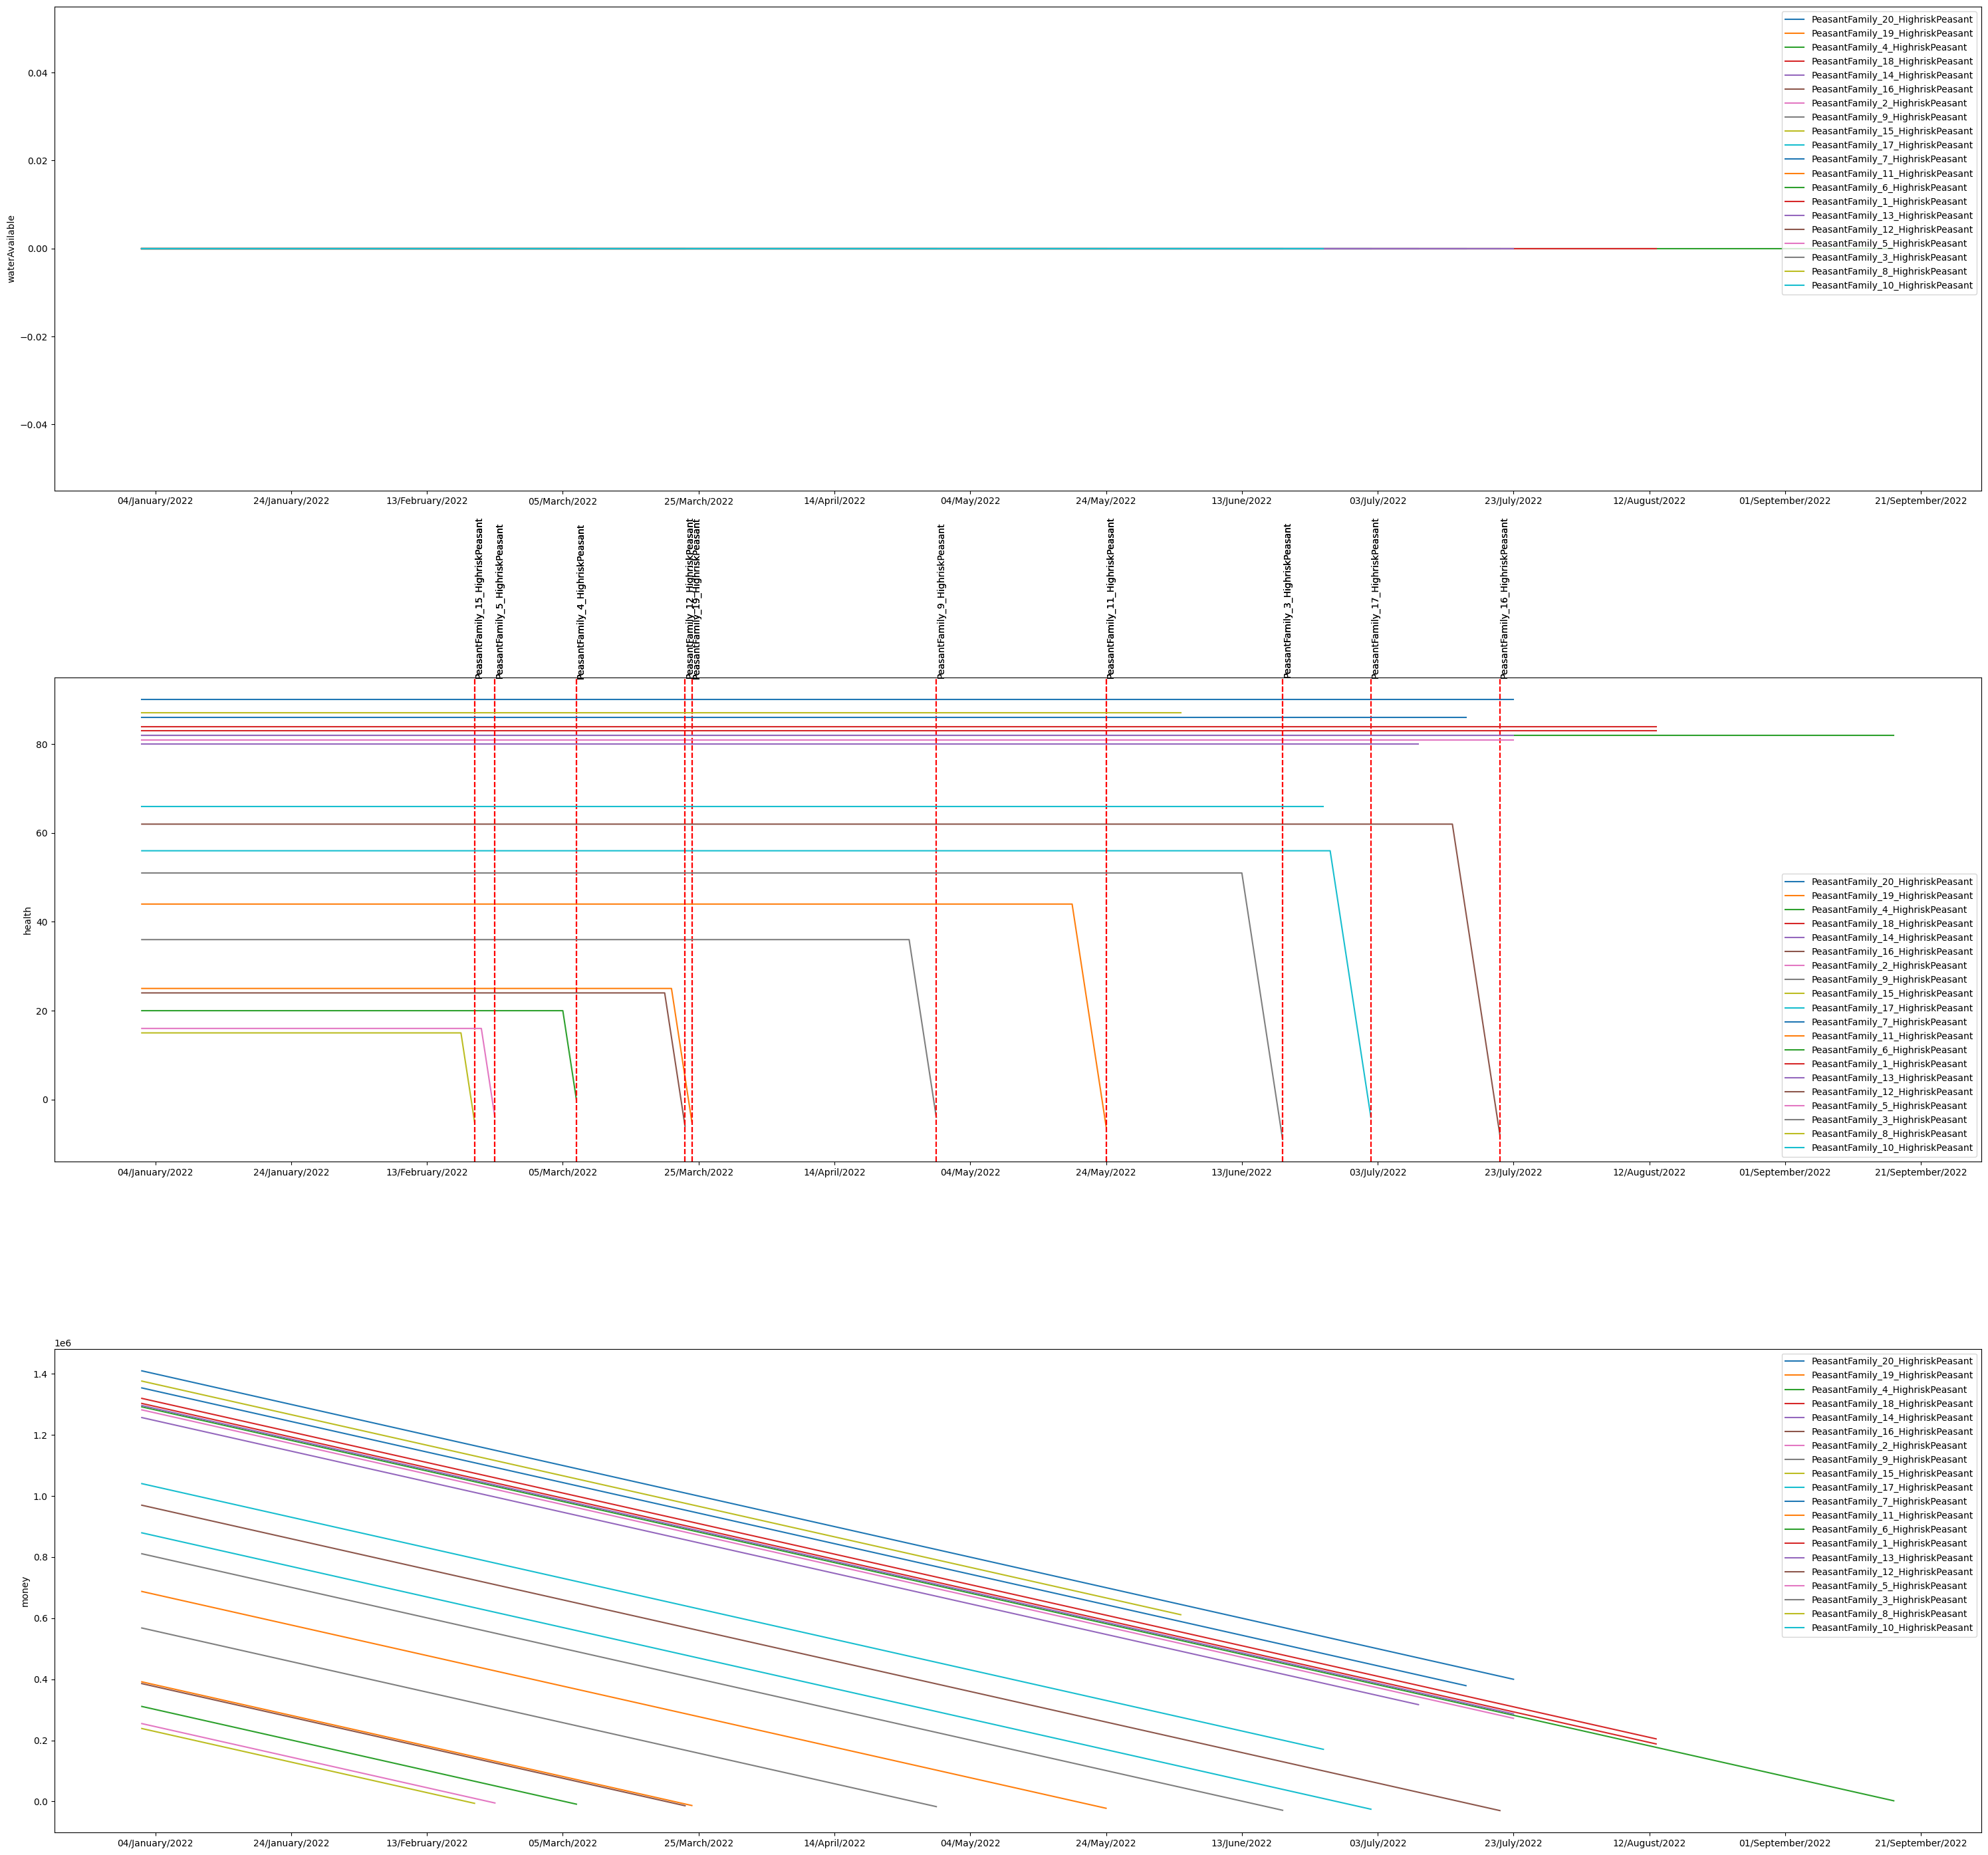

In [25]:
# Asegurando que 'internalCurrentDate' sea una fecha
df01['internalCurrentDate'] = pd.to_datetime(df01['internalCurrentDate'], dayfirst=True)

# Convirtiendo las columnas a formato numérico
numeric_columns = ['waterAvailable', 'health', 'money']
for column in numeric_columns:
    df01[column] = pd.to_numeric(df01[column], errors='coerce')

# Combinar las columnas 'peasantProfile' y 'peasantKind' en una nueva columna 'label'
df01['label'] = df01['peasantProfile'] + '_' + df01['peasantKind']

# Crear una figura y ejes para cada variable
fig, axs = plt.subplots(3, 1, figsize=(30, 28))

# Generar la gráfica para 'waterAvailable'
for label in df01['label'].unique():
    df_label = df01[df01['label'] == label]
    df_label = df_label.sort_values('internalCurrentDate')
    axs[0].plot(df_label['internalCurrentDate'], df_label['waterAvailable'], label=label)

axs[0].set_ylabel('waterAvailable')
axs[0].legend()
axs[0].xaxis.set_major_locator(mdates.DayLocator(interval=20))
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%d/%B/%Y'))

# Generar la gráfica para 'health'
for label in df01['label'].unique():
    df_label = df01[df01['label'] == label]
    df_label = df_label.sort_values('internalCurrentDate')
    axs[1].plot(df_label['internalCurrentDate'], df_label['health'], label=label)

    # Añadir una línea vertical cuando 'health' es menor o igual a 0
    zero_or_less_health_dates = df_label[df_label['health'] <= 0]['internalCurrentDate']
    for date in zero_or_less_health_dates:
        axs[1].axvline(date, color='r', linestyle='--')
        axs[1].text(date, axs[1].get_ylim()[1], label, rotation=90, verticalalignment='bottom')

axs[1].set_ylabel('health')
axs[1].legend()
axs[1].xaxis.set_major_locator(mdates.DayLocator(interval=20))
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%d/%B/%Y'))

# Generar la gráfica para 'money'
for label in df01['label'].unique():
    df_label = df01[df01['label'] == label]
    df_label = df_label.sort_values('internalCurrentDate')
    axs[2].plot(df_label['internalCurrentDate'], df_label['money'], label=label)

axs[2].set_ylabel('money')
axs[2].legend()
axs[2].xaxis.set_major_locator(mdates.DayLocator(interval=20))
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%d/%B/%Y'))

# Ajustar la presentación de los gráficos
plt.tight_layout()

# Mostrar la gráfica unificada
plt.show()

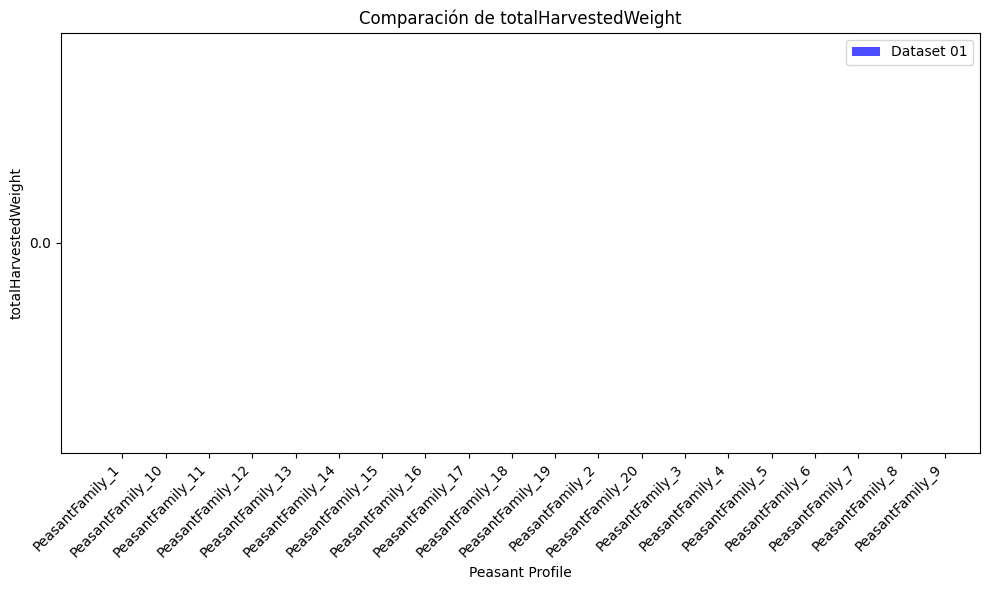

In [26]:
# Crear la gráfica de barras para totalHarvestedWeight
df_last_01 = df01.groupby('peasantProfile').last().reset_index()

total_harvested_weights_01 = df_last_01['totalHarvestedWeight']

x = np.arange(len(total_harvested_weights_01))  # Posiciones de las barras
width = 0.3  # Ancho de las barras

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width, total_harvested_weights_01, width, label='Dataset 01', color='blue', alpha=0.7)

# Etiquetas en el eje x
ax.set_xticks(x)
ax.set_xticklabels(df_last_01['peasantProfile'], rotation=45, ha='right')

ax.set_ylabel('totalHarvestedWeight')
ax.set_xlabel('Peasant Profile')
ax.set_title('Comparación de totalHarvestedWeight')

ax.legend()
plt.tight_layout()
plt.show()

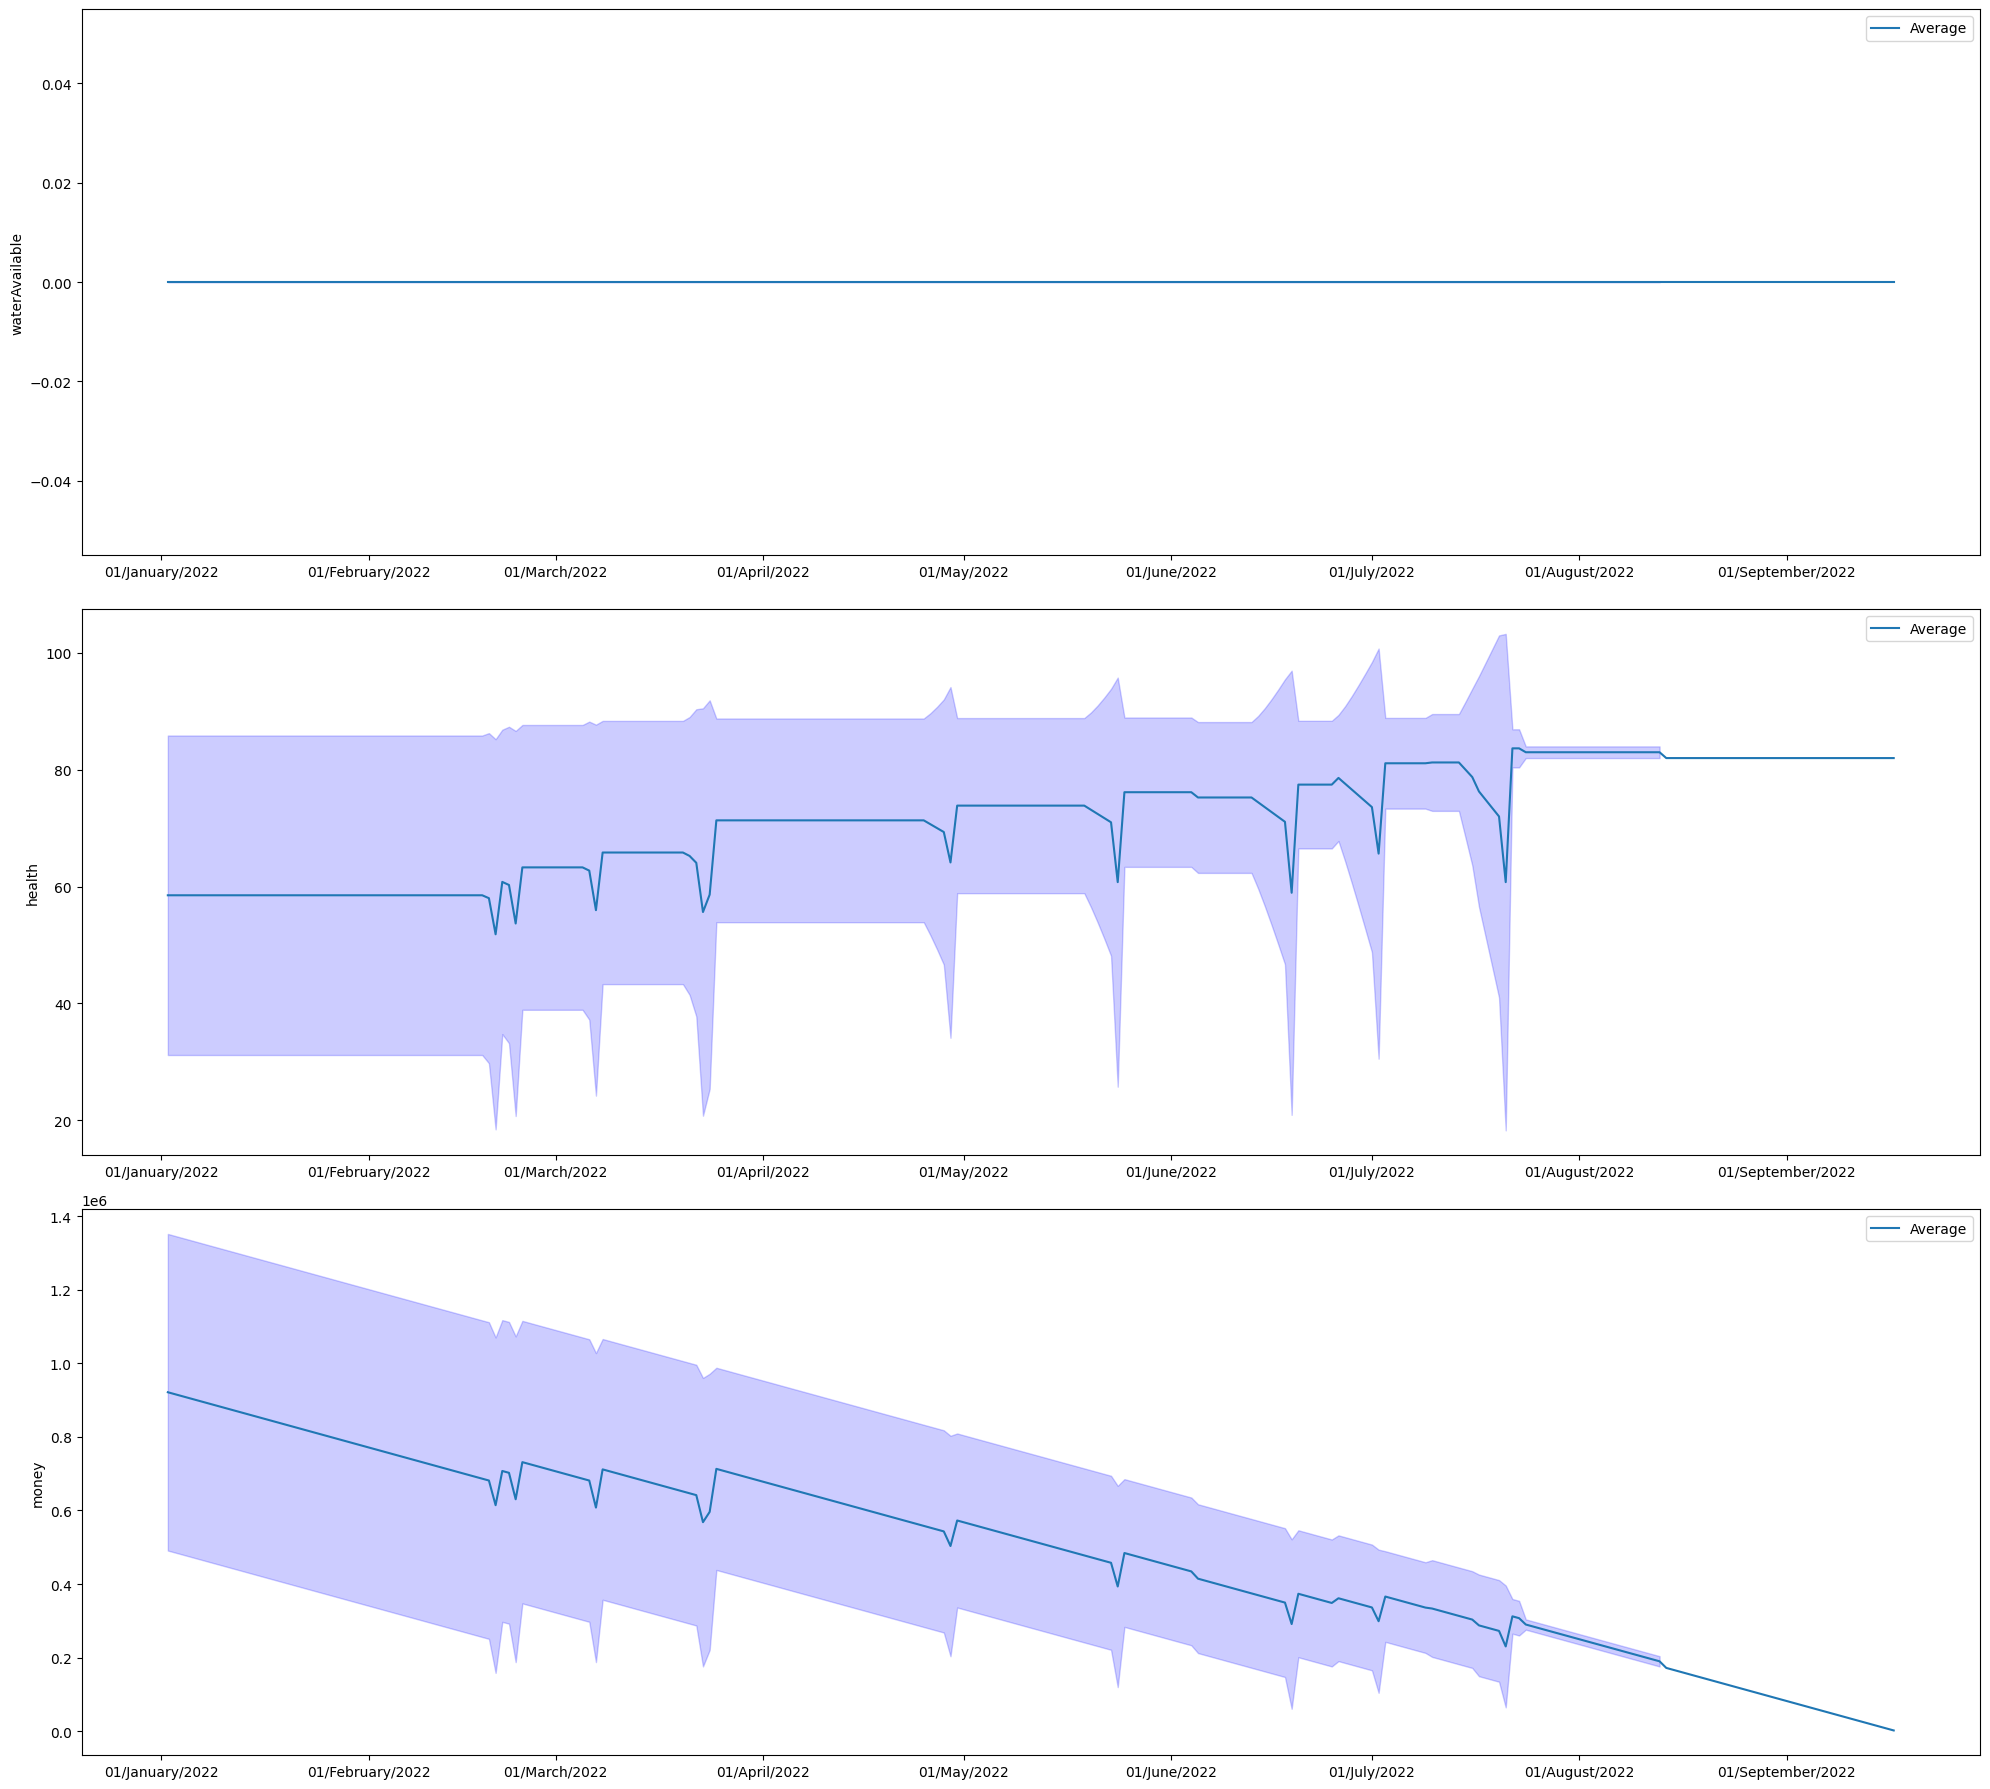

In [27]:
# Crear una figura y ejes para cada variable
fig, axs = plt.subplots(3, 1, figsize=(20, 18))

# Generar la gráfica para 'waterAvailable'
df_grouped = df01.groupby('internalCurrentDate')['waterAvailable'].agg(['mean', 'std'])
axs[0].plot(df_grouped.index, df_grouped['mean'], label='Average')
axs[0].fill_between(df_grouped.index, df_grouped['mean'] - df_grouped['std'], df_grouped['mean'] + df_grouped['std'], color='b', alpha=0.2)
axs[0].set_ylabel('waterAvailable')
axs[0].legend()
axs[0].xaxis.set_major_locator(mdates.MonthLocator())
axs[0].xaxis.set_major_formatter(mdates.DateFormatter('%d/%B/%Y'))

# Generar la gráfica para 'health'
df_grouped = df01.groupby('internalCurrentDate')['health'].agg(['mean', 'std'])
axs[1].plot(df_grouped.index, df_grouped['mean'], label='Average')
axs[1].fill_between(df_grouped.index, df_grouped['mean'] - df_grouped['std'], df_grouped['mean'] + df_grouped['std'], color='b', alpha=0.2)
axs[1].set_ylabel('health')
axs[1].legend()
axs[1].xaxis.set_major_locator(mdates.MonthLocator())
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%d/%B/%Y'))

# Generar la gráfica para 'money'
df_grouped = df01.groupby('internalCurrentDate')['money'].agg(['mean', 'std'])
axs[2].plot(df_grouped.index, df_grouped['mean'], label='Average')
axs[2].fill_between(df_grouped.index, df_grouped['mean'] - df_grouped['std'], df_grouped['mean'] + df_grouped['std'], color='b', alpha=0.2)
axs[2].set_ylabel('money')
axs[2].legend()
axs[2].xaxis.set_major_locator(mdates.MonthLocator())
axs[2].xaxis.set_major_formatter(mdates.DateFormatter('%d/%B/%Y'))

# Ajustar la presentación de los gráficos
plt.tight_layout()

# Mostrar la gráfica unificada
plt.show()

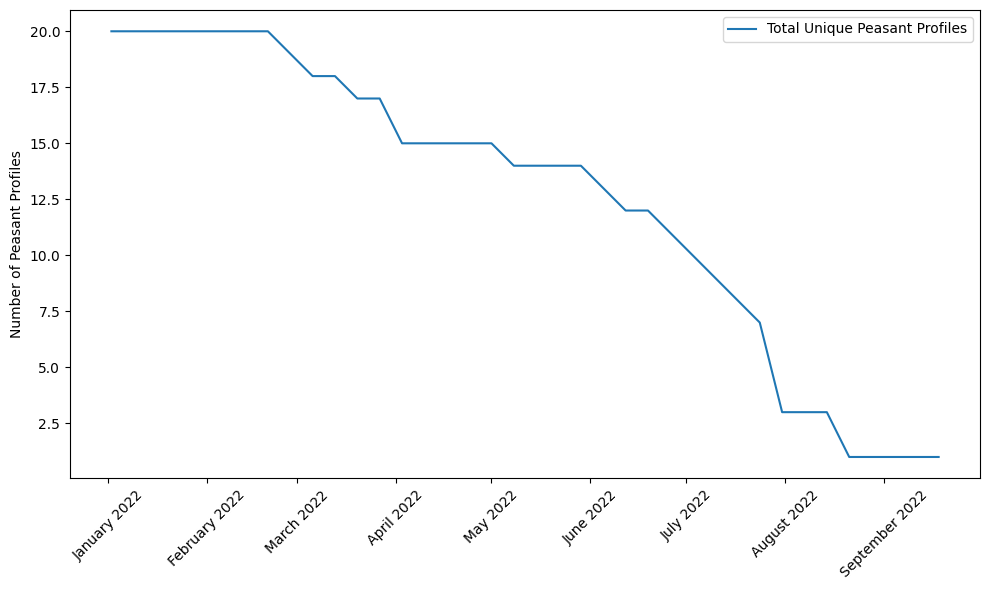

In [28]:
# Asegurando que 'internalCurrentDate' sea una fecha
df01['internalCurrentDate'] = pd.to_datetime(df01['internalCurrentDate'], dayfirst=True)

# Establecer 'internalCurrentDate' como índice para permitir la reasignación
df01.set_index('internalCurrentDate', inplace=True)

# Contar el número de 'peasantProfile' únicos para cada semana
df_count = df01.resample('W')['peasantProfile'].nunique()

# Restablecer el índice para 'internalCurrentDate'
df01.reset_index(inplace=True)

# Crear una figura
fig, ax = plt.subplots(figsize=(10, 6))

# Generar la gráfica para el número total de agentes
ax.plot(df_count.index, df_count, label='Total Unique Peasant Profiles')
ax.set_ylabel('Number of Peasant Profiles')
ax.legend()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%B %Y'))

# Girar las etiquetas de las fechas para una mejor visualización
plt.xticks(rotation=45)

# Ajustar la presentación del gráfico
plt.tight_layout()

# Mostrar la gráfica
plt.show()